# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [285]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data



In [286]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
feat_info.shape

(85, 4)

In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [11]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"




## Step 1: Preprocessing



In [12]:
# Identify missing or unknown data values and convert them to NaNs.
# pre missing values converted to NaN

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [14]:
# check what values represent missing values

feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [288]:
# use regular expression to go through the feat_info dataframe and get the values relating to missing data

new_list = []
for index in range(len(feat_info)):
    find = re.findall(r'\[(.*?)\]', feat_info['missing_or_unknown'][index])
    new = find[0].split(',')
    new_list.append(new)

In [289]:
# create new dictionary with attribute name and missing values

missing_key = dict(zip(feat_info.attribute, new_list))

In [290]:
# cycle through new dictionary to replace missing values with numpy nan values

for key, value in missing_key.items():
    for val in value:
        if val not in ['XX', 'X', '']:
            val = int(val)
            azdias[key] = azdias[key].replace(val, np.NaN)
        elif val != '':
            azdias[key] = azdias[key].replace(val, np.NaN)

In [19]:
# post converting missing values to NaN to make sure the loop worked

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

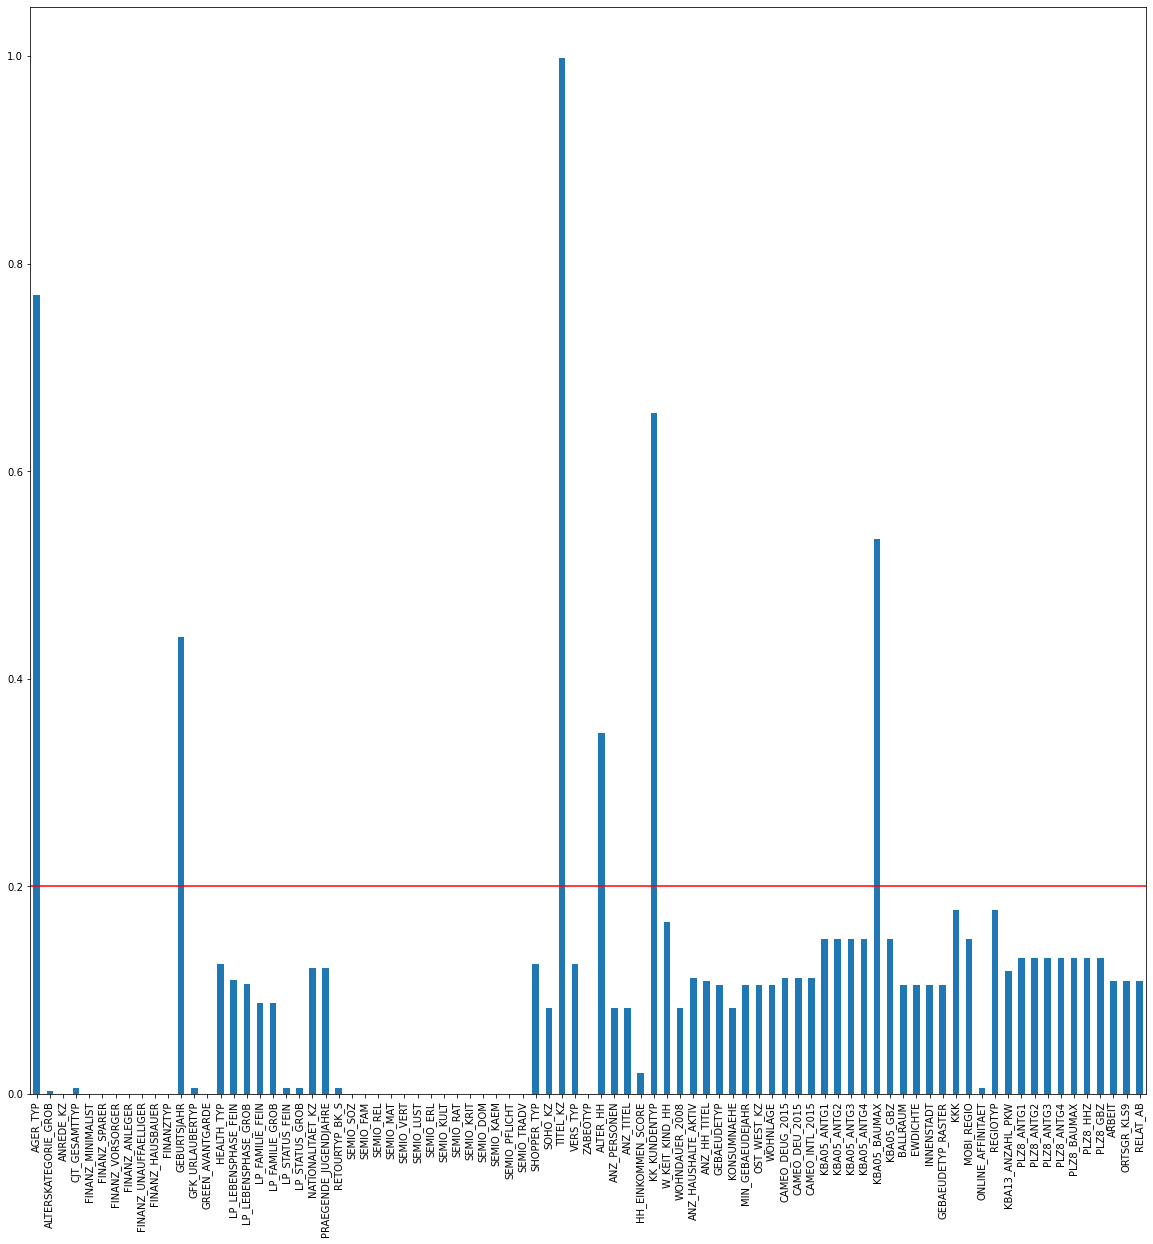

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

ax = azdias.isnull().mean().plot.bar(figsize=(20,20))
ax.axhline(.2, color='red');

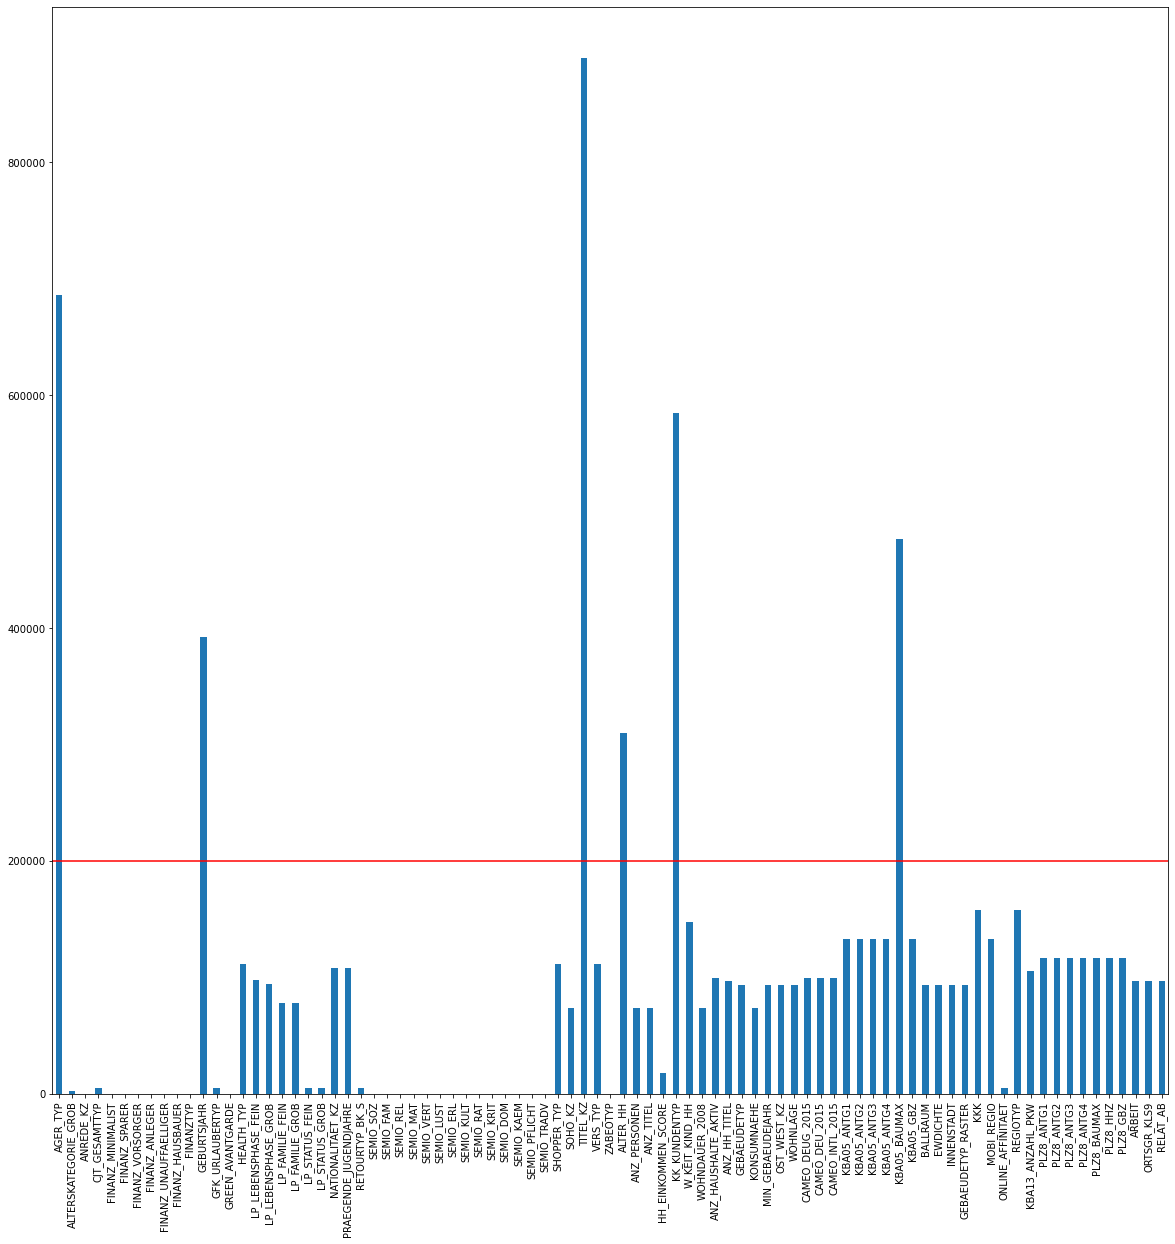

In [21]:
ax = azdias.isnull().sum().plot.bar(figsize=(20,20))
ax.axhline(200000, color='red');

In [22]:
azdias.isnull().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [23]:
azdias.isnull().mean()

AGER_TYP                0.769554
ALTERSKATEGORIE_GROB    0.003233
ANREDE_KZ               0.000000
CJT_GESAMTTYP           0.005446
FINANZ_MINIMALIST       0.000000
                          ...   
PLZ8_HHZ                0.130736
PLZ8_GBZ                0.130736
ARBEIT                  0.109260
ORTSGR_KLS9             0.109147
RELAT_AB                0.109260
Length: 85, dtype: float64

In [24]:
# Investigate patterns in the amount of missing data in each column.
miss_data = []
for name in azdias.columns:
    if azdias[name].isnull().mean() > .2:
        miss_data.append(name)


In [25]:
azdias[miss_data]

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1996.0,NaN,NaN,NaN,5.0
2,NaN,1979.0,NaN,17.0,NaN,NaN
3,2.0,1957.0,NaN,13.0,NaN,1.0
4,NaN,1963.0,NaN,20.0,1.0,NaN
...,...,...,...,...,...,...
891216,NaN,1976.0,NaN,17.0,3.0,NaN
891217,NaN,1970.0,NaN,16.0,NaN,5.0
891218,NaN,1976.0,NaN,17.0,NaN,NaN
891219,NaN,1994.0,NaN,NaN,NaN,NaN


In [26]:
azdias[miss_data].describe()

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
count,205378.000000,498903.000000,2160.000000,580954.000000,306609.000000,414697.000000
mean,1.743410,1967.102689,1.318519,15.291805,3.410640,2.539534
std,0.674312,17.795208,0.999504,3.800536,1.628844,1.693151
min,1.000000,1900.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1955.000000,1.000000,13.000000,2.000000,1.000000
50%,2.000000,1968.000000,1.000000,16.000000,3.000000,1.000000
75%,2.000000,1981.000000,1.000000,18.000000,5.000000,4.000000
max,3.000000,2017.000000,5.000000,21.000000,6.000000,5.000000


In [291]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(miss_data, axis=1, inplace=True)

#### Assess Missing Data in Each Column

I looked at the mean and sums of each of the columns in the dataset to see if there were any that were missing a lot of data and why that could be. I found six columns that were missing over 20% of their data and over 200,000 values. Those columns and their descriptions from the data dictionary were:

- AGER_TYP: Age Typology
- GEBURTSJAHR: Year of Birth
- TITEL_KZ: Academic Title
- ALTER_HH: Birthdate of Head of Household
- KK_KUNDENTYP: Consumer Pattern Last 12 Months
- KBA05_BAUMAX: Most Common Building Type Within the Microcell

Consumer pattern could be helpful if all the data was there but with so much missing it won't do me much good. The rest of the columns I should be fine without. 



#### Step 1.1.3: Assess Missing Data in Each Row



In [293]:
# How much data is missing in each row of the dataset?
azdias.isna().mean(axis = 1)

0         0.544304
3         0.088608
11        0.594937
12        0.075949
13        0.101266
            ...   
891203    0.177215
891208    0.037975
891216    0.037975
891217    0.050633
891218    0.063291
Length: 268012, dtype: float64

In [294]:
# # How much data is missing in each row of the dataset?

# for index in range(len(azdias)):
#     missing_percent = round(azdias.iloc[index].isna().mean(), 4) * 100
#     print("Missing percentage in row {} is: {}%".format(index, missing_percent))

In [102]:
# get how much data would be cut out based on different thresholds

perc_missing = [.1, .2, .3, .4, .5, .6]
sum_missing = []

for perc in perc_missing:
    total = sum(azdias.isna().mean(axis=1) > perc)
    sum_missing.append(total)

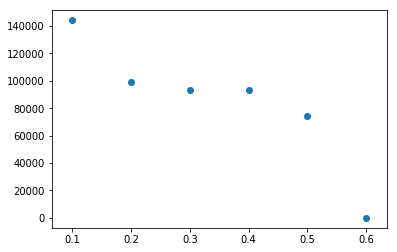

In [106]:
# checking to see what threshold makes the most sense

plt.scatter(perc_missing, sum_missing)

In [28]:
# creating list of indexes for rows that are missing more than 20% of it's data

above = [index for index in range(len(azdias)) if azdias.iloc[index].isnull().mean() > .2]

In [29]:
# creating list of indexes for rows that are missing less than 20% of it's data

below = [index for index in range(len(azdias)) if azdias.iloc[index].isnull().mean() < .2]

In [30]:
# drop and create the subsets for above and below 20% of missing data

azdias_full = azdias.drop(above)
azdias_empty = azdias.drop(below)

In [31]:
azdias_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792287 entries, 1 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   789547 non-null  float64
 1   ANREDE_KZ              792287 non-null  int64  
 2   CJT_GESAMTTYP          787919 non-null  float64
 3   FINANZ_MINIMALIST      792287 non-null  int64  
 4   FINANZ_SPARER          792287 non-null  int64  
 5   FINANZ_VORSORGER       792287 non-null  int64  
 6   FINANZ_ANLEGER         792287 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  792287 non-null  int64  
 8   FINANZ_HAUSBAUER       792287 non-null  int64  
 9   FINANZTYP              792287 non-null  int64  
 10  GFK_URLAUBERTYP        787919 non-null  float64
 11  GREEN_AVANTGARDE       792287 non-null  int64  
 12  HEALTH_TYP             756432 non-null  float64
 13  LP_LEBENSPHASE_FEIN    743486 non-null  float64
 14  LP_LEBENSPHASE_GROB    746286 non-nu

In [32]:
azdias_empty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98934 entries, 0 to 891187
Data columns (total 79 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ALTERSKATEGORIE_GROB   98793 non-null  float64
 1   ANREDE_KZ              98934 non-null  int64  
 2   CJT_GESAMTTYP          98448 non-null  float64
 3   FINANZ_MINIMALIST      98934 non-null  int64  
 4   FINANZ_SPARER          98934 non-null  int64  
 5   FINANZ_VORSORGER       98934 non-null  int64  
 6   FINANZ_ANLEGER         98934 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  98934 non-null  int64  
 8   FINANZ_HAUSBAUER       98934 non-null  int64  
 9   FINANZTYP              98934 non-null  int64  
 10  GFK_URLAUBERTYP        98448 non-null  float64
 11  GREEN_AVANTGARDE       98934 non-null  int64  
 12  HEALTH_TYP             23593 non-null  float64
 13  LP_LEBENSPHASE_FEIN    50103 non-null  float64
 14  LP_LEBENSPHASE_GROB    50363 non-null  float64
 15  L

In [39]:
def show_value_distribution(column):
    
    '''
    Shows distribution of code frequencies of column between the two different dataframes. One that has considerable
    missing data (more than 20%) per row and one that has almost all the data available.
    
    input:
    column - string: column that you want to compare.
    output:
    seaborn countplot of the columns
    '''

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Value Distribution Comparisions")

    sns.countplot(x = azdias_full[column], ax = axes[0])
    axes[0].set_title("Missing Little to No Data")
    sns.countplot(x = azdias_empty[column], ax = axes[1])
    axes[1].set_title("Missing Significant Data");

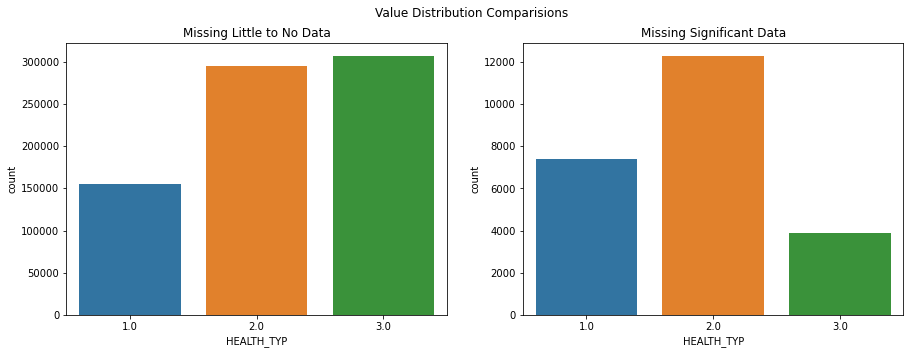

In [40]:
show_value_distribution('HEALTH_TYP')

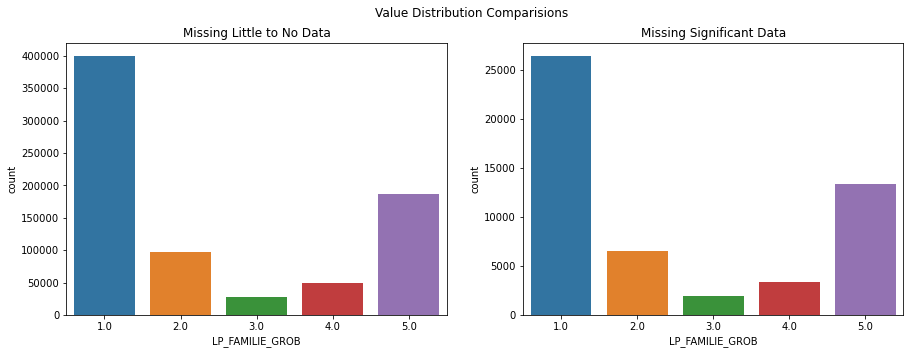

In [42]:
show_value_distribution('LP_FAMILIE_GROB')

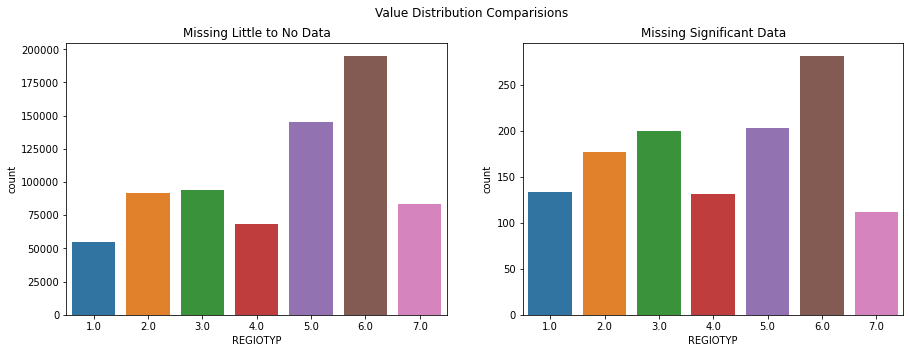

In [43]:
show_value_distribution('REGIOTYP')

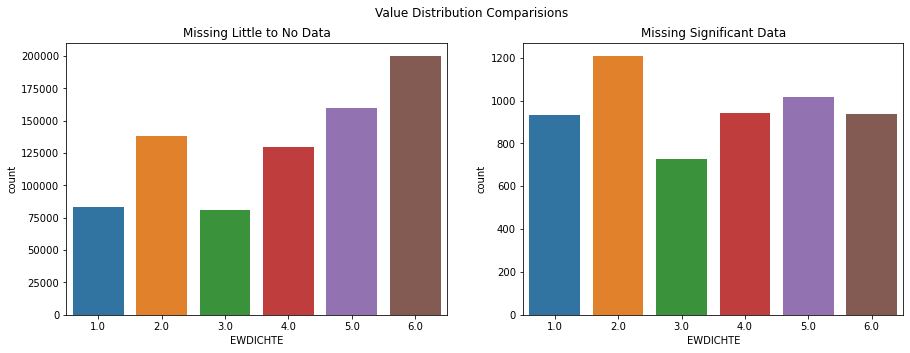

In [44]:
show_value_distribution('EWDICHTE')

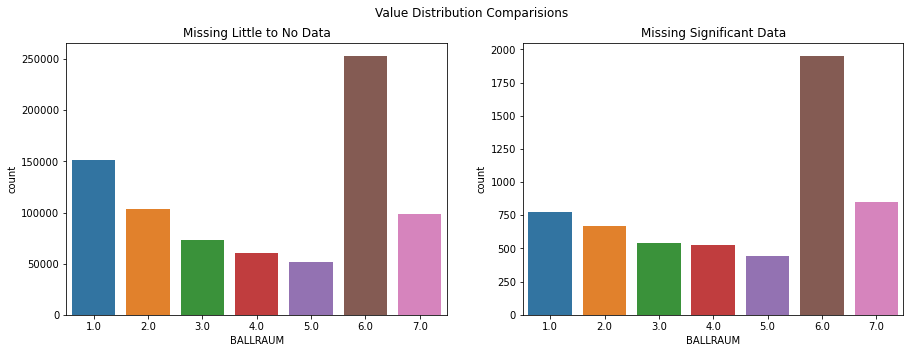

In [45]:
show_value_distribution('BALLRAUM')

#### Assess Missing Data in Each Row

Looking at what was missing from each row visually would be far too time consuming even after printing out everything that was missing for each line, so I created a graph that increased the allowed percentage of data by 10% each time to see if I could find a point where I could create a reasonable threshold. Sort of like finding the elbow point with K means I found that allowing for 20% of missing data in a row was reasonable. 10% cut out too much data and then allowing rows with 60% of missing data was just too much. You can see in the graph above that it evens out from 20 to 50% before another big drop off at 60%. 

Once the data was split I found that looking at the distributions of values between my full data set and the data set that had a large amount of missing data (empty) I didn't see much difference in distributions between the five randomly chosen columns. The one column that was slightly off between the two datasets was the HEALTH_TYP column where the number of 3 values were significantly higher in the full data set as opposed to the empty data set. Despite that, I believe I'd be safe in just dropping the rows that are misssing more than 20% of the data based on the distribution in the columns I checked. 

In [47]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

**I would prefer to have a features info summary dataframe that only has the same columns as the Azdias dataframe I dropped colums from so I'm going to create a new one so that I can go through this next section without columns that aren't in the actual dataset.**

In [49]:
# check columns I dropped earlier
miss_data

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [50]:
# create list of indexes to drop from feat_info
drop_index = []

for index in range(len(feat_info)):
    if feat_info['attribute'][index] in miss_data:
        drop_index.append(index)

In [51]:
feat_info_full = feat_info.drop(drop_index)

####  Re-Encode Categorical Features



In [55]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_cats = feat_info_full.query("type == 'categorical'")
feat_cats.reset_index(drop=True, inplace=True)

In [56]:
for index in range(len(feat_cats)):
    col_name = feat_cats['attribute'][index]
    print("Column: {}, Variables: {}".format(col_name, azdias_full[col_name].unique()))

Column: ANREDE_KZ, Variables: [2 1]
Column: CJT_GESAMTTYP, Variables: [ 5.  3.  2.  4.  1.  6. nan]
Column: FINANZTYP, Variables: [1 6 5 2 4 3]
Column: GFK_URLAUBERTYP, Variables: [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
Column: GREEN_AVANTGARDE, Variables: [0 1]
Column: LP_FAMILIE_FEIN, Variables: [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
Column: LP_FAMILIE_GROB, Variables: [ 3.  1. nan  5.  2.  4.]
Column: LP_STATUS_FEIN, Variables: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
Column: LP_STATUS_GROB, Variables: [ 1.  2.  4.  5.  3. nan]
Column: NATIONALITAET_KZ, Variables: [ 1.  3.  2. nan]
Column: SHOPPER_TYP, Variables: [ 3.  2.  1.  0. nan]
Column: SOHO_KZ, Variables: [1. 0.]
Column: VERS_TYP, Variables: [ 2.  1. nan]
Column: ZABEOTYP, Variables: [5 3 4 1 6 2]
Column: GEBAEUDETYP, Variables: [8. 1. 3. 2. 6. 4. 5.]
Column: OST_WEST_KZ, Variables: ['W' 'O']
Column: CAMEO_DEUG_2015, Variables: ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
Column: CAMEO_DEU_2015, Var

In [57]:
# Mapping OST_WEST_KZ column from 'W' and 'O' to 1 and 0. Will map W (West Germany) to 0 and O (East Germany) to 1
azdias_full['OST_WEST_KZ'] = azdias_full['OST_WEST_KZ'].map({'W': 0, 'O': 1})


In [121]:
# columns I plan on keeping
keep_list = ['CJT_GESAMTTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']

In [87]:
def encode_columns(column_list, df):
    """
    Takes in a list of columnn for dummy variable creation.
    
    Inupts
    column_list - list: list of column names you want to encode with dummy variables
    df - dataframe: dataframe that contains the column names you want to encode.
    
    Output
    df - dataframe with newly encoded columns and dropped original columns.
    
    """
    
    for col in column_list:
        dummy_df = pd.get_dummies(azdias_full[col], prefix=col)
        df = df.join(dummy_df)
        df.drop(col, axis=1, inplace=True)
        
    return df
    

In [122]:
azdias_encoded = encode_columns(keep_list, azdias_full)

In [123]:
azdias_encoded.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792287 entries, 1 to 891220
Data columns (total 119 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ALTERSKATEGORIE_GROB   float64
 1   ANREDE_KZ              int64  
 2   FINANZ_MINIMALIST      int64  
 3   FINANZ_SPARER          int64  
 4   FINANZ_VORSORGER       int64  
 5   FINANZ_ANLEGER         int64  
 6   FINANZ_UNAUFFAELLIGER  int64  
 7   FINANZ_HAUSBAUER       int64  
 8   FINANZTYP              int64  
 9   GFK_URLAUBERTYP        float64
 10  GREEN_AVANTGARDE       int64  
 11  HEALTH_TYP             float64
 12  LP_LEBENSPHASE_FEIN    float64
 13  LP_LEBENSPHASE_GROB    float64
 14  LP_FAMILIE_GROB        float64
 15  LP_STATUS_GROB         float64
 16  NATIONALITAET_KZ       float64
 17  PRAEGENDE_JUGENDJAHRE  float64
 18  RETOURTYP_BK_S         float64
 19  SEMIO_SOZ              int64  
 20  SEMIO_FAM              int64  
 21  SEMIO_REL              int64  
 22  SEMIO_MAT          

In [132]:
# dropping remainding multilevel columns.
drop_multilevel = ['GFK_URLAUBERTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'GEBAEUDETYP', \
                   'CAMEO_DEU_2015']
azdias_encoded.drop(drop_multilevel, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

**Already Binary:**
- Andrede_KZ
- Green_Avantgarde
- Soho_KZ
- Vers_Typ
- OST_West_KZ: Mapped W (West Germany) to 0 and O (East Germany) to 1

**Keep:**
- CJT_GESAMTTYP: Deals with information and buying channels for consumer, should have an impact on how someone shops. 
- LP_FAMILIE_FEIN: Deals with family type, should help show how certain family types behave in terms of shopping. 
- LP_STATUS_FEIN: Deals with social status based on earnings, should have an impact on how a person spends money. 
- SHOPPER_TYP: Deals with shopper type which should have an impact on results.
- ZABEOTYP: Deals with energy consumption (i.e green, smart housing), for mail orders/physical order guides this could be important. 
- CAMEO_DEUG_2015: Deals with Wealth/Life stage in reasonable stages. 

**Drop:**
- GFK_URLAUBERTYP: This deals with vacation habits and I don't believe vacation habits to have a large impact on mail-order shopping. 
- FINANZTYP: Deals with financial descriptors and could possibly be helpful but certain types ('be prepared' and 'inconspicuous') aren't well defined so not sure what it would be providing. 
- LP_FAMILIE_GROB: Deals with family type but in less detail than LP_FAMILIE_FEIN. 
- LP_STATUS_GROB: Deals with social status but in less detail than LP_FAMILIE_FEIN.
- NATIONALITAET_KZ: Deals with nationality but only based on how a name sounds, don't believe this would be helpful. 
- GEBAEUDETYP: Deals with building type, mailing is available to all home types. 
- CAMEO_DEUG_2015: Deals with Wealth/Life stage in reasonable stages, however due to 
- CAMEO_DEU_2015: Deas with Wealth/Life stage but in extremely high detail that I don't believe will have more impact than the CAMEO_DEUG_2015 column. 

**Data Changes**
- Once I had the columns I was going to keep I created a function that took that list and the dataframe and encoded all the new variables using get_dummies from Pandas and then added those to a new data frame azdias_encoded. 

#### Engineer Mixed-Type Features



In [93]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_encoded.PRAEGENDE_JUGENDJAHRE.unique()


array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [94]:
azdias_encoded.PRAEGENDE_JUGENDJAHRE.value_counts(dropna=False)

14.0    181525
8.0     140681
10.0     85276
5.0      84400
3.0      53615
15.0     42078
11.0     35448
9.0      33515
NaN      27615
6.0      25629
12.0     24340
1.0      20550
4.0      20431
2.0       7470
13.0      5714
7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

**Handle the Movement variable first as it's a simple binary. Will map to 1 or 0 for whether or not they were apart of the 
mainstream movement.**

In [81]:
movement = {'mainstream': [1, 3, 5, 8, 10, 12, 14], 'avantgarde': [2, 4, 6, 7, 9, 11, 13, 15]}

In [133]:
azdias_encoded['MAINSTREAM'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in movement['mainstream'] else 0)

In [134]:
azdias_encoded.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [135]:
azdias_encoded.MAINSTREAM.head()

1    1
2    0
3    1
4    1
5    1
Name: MAINSTREAM, dtype: int64

**Next I'll handle the decade by mapping each value to a decade and then creating a dummy variable for those decades.**

In [98]:
decade_dict = {1: '40s', 2:'40s', 3:'50s', 4:'50s', 5:'60s', 6:'60s',\
              7:'60s', 8:'70s', 9:'70s', 10:'80s', 11:'80s', 12:'80s',\
              13:'80s', 14:'90s', 15:'90s'}

In [136]:
# create new column for decade
azdias_encoded['decade'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)

In [137]:
# create dummy variables and add to dataframe
azdias_encoded = azdias_encoded.join(pd.get_dummies(azdias_encoded['decade'], prefix='DECADE'))

In [138]:
# drop original PRAEGENDE_JUGENDJAHRE column and decade column. 
azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'decade'], axis=1, inplace=True)

In [139]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_encoded.CAMEO_INTL_2015.value_counts(dropna=False)

51     133492
41      92080
24      90699
14      62565
43      56495
54      45287
25      39413
22      32931
13      26162
45      26038
23      26028
55      23866
52      20508
31      18661
34      18445
15      16913
44      14776
12      13136
35      10316
32      10304
33       9856
NaN      4316
Name: CAMEO_INTL_2015, dtype: int64

In [103]:
azdias_encoded.CAMEO_INTL_2015.unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

**Since the values are represented by first and second numbers (Wealth and Life Stage respectively) I'll create two new columns by pulling the corresponding number to represent Wealth and Life Stage from the original column.**

In [140]:
# set up the Wealth column while ignoring NaN values
azdias_encoded['WEALTH'] = azdias_encoded['CAMEO_INTL_2015'].apply(lambda x: None if str(x)[0] == 'n' else int(str(x)[0]))

In [141]:
# set up the Life Stage column while ignoring NaN values
azdias_encoded['LIFE_STAGE'] = azdias_encoded['CAMEO_INTL_2015'].apply(lambda x: None if str(x)[0] == 'n' else int(str(x)[1]))

In [142]:
wealth_df = pd.get_dummies(azdias_encoded['WEALTH'], prefix='WEALTH')

In [143]:
life_df = pd.get_dummies(azdias_encoded['LIFE_STAGE'], prefix='LIFE_STAGE')

In [144]:
azdias_encoded = azdias_encoded.join([life_df, wealth_df])

In [145]:
azdias_encoded.drop('CAMEO_INTL_2015', axis=1, inplace=True)

**Find and drop remainding mixed feature columns.**

In [110]:
feat_info_full.query("type == 'mixed'")

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [113]:
drop_encoded = ['WEALTH', 'LIFE_STAGE', 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [146]:
azdias_encoded.drop(drop_encoded, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the PRAEGENDE_JUGENDJAHRE column, according to the data dictionary, each number represents both the decade of youth and what movement they were apart of (mainstream or avantgarde). It also describes what part of Germany (East or West) but some are mixed so makes it too difficult to break out into new variables. I broke the original column into two new variables, decade and movement. Movement was broken into a binary column since they were either mainstream or avantgarde. For decade I created dummy variables for each decade and added those to the dataframe. The original column PRAEGENDE_JUGENDJAHRE was then dropped. 

For the CAMEO_INTL_2015 column each value represent Wealth (1 - Wealthy through 5 - Poorer Households) and Life Stage (1 Pre Family Couples/Single through 5 - Elders in Retirement) so for example a value that is 15 represents a Wealthy Elder in Retirement. Since each number represented something new I simply pulled the first number for a Wealth column, and then the second number for Stage of Life. Once I had those I created dummy variables for each column and then dropped the original column. 

I decided to drop the rest of the mixed type features. 

####  Complete Feature Selection



In [147]:
# checking to make sure that I only had the columns I just encoded and were either numeric, interval, or ordinal already
azdias_encoded.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 792287 entries, 1 to 891220
Data columns (total 124 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ALTERSKATEGORIE_GROB   float64
 1   ANREDE_KZ              int64  
 2   FINANZ_MINIMALIST      int64  
 3   FINANZ_SPARER          int64  
 4   FINANZ_VORSORGER       int64  
 5   FINANZ_ANLEGER         int64  
 6   FINANZ_UNAUFFAELLIGER  int64  
 7   FINANZ_HAUSBAUER       int64  
 8   GREEN_AVANTGARDE       int64  
 9   HEALTH_TYP             float64
 10  LP_LEBENSPHASE_GROB    float64
 11  RETOURTYP_BK_S         float64
 12  SEMIO_SOZ              int64  
 13  SEMIO_FAM              int64  
 14  SEMIO_REL              int64  
 15  SEMIO_MAT              int64  
 16  SEMIO_VERT             int64  
 17  SEMIO_LUST             int64  
 18  SEMIO_ERL              int64  
 19  SEMIO_KULT             int64  
 20  SEMIO_RAT              int64  
 21  SEMIO_KRIT             int64  
 22  SEMIO_DOM          

### Create a Cleaning Function



In [232]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    new_list = []
    
    for index in range(len(feat_info)):
        find = re.findall(r'\[(.*?)\]', feat_info['missing_or_unknown'][index])
        new = find[0].split(',')
        new_list.append(new)
    
    miss_dict = dict(zip(feat_info['attribute'], new_list))
    
    for key, value in miss_dict.items():
        for val in value:
            if val not in ['XX', 'X', '']:
                val = int(val)
                df[key] = df[key].replace(val, np.NaN)
            elif val != '':
                df[key] = df[key].replace(val, np.NaN)
    
    # remove selected columns and rows, ...
    
    # list of columns removed from population data due to missing data values
    
    drop_list = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

    df.drop(drop_list, axis=1, inplace=True)
    
    above = [index for index in range(len(df)) if df.iloc[index].isnull().mean() > .2]
    
    df.drop(above, inplace=True) 
    
    # select, re-encode, and engineer column values.
    
    # encoding the columns to keep with dummy variables
    
    keep_list = ['CJT_GESAMTTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']

    for col in keep_list:
        dummy_df = pd.get_dummies(df[col], prefix=col)
        df = df.join(dummy_df)
        df.drop(col, axis=1, inplace=True)
        
    
    # Encoding the OST_WEST_KZ binary column to 1 and 0
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # encode multilevel column PRAEGENDE_JUGENDJAHRE and drop original column
    
    movement = {'mainstream': [1,3,5,8,10,12,14], 'avantgarde': [2,4,6,7,9,11,13,15]}
    
    df['MAINSTREAM'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in movement['mainstream'] else 0)
    
    decade_dict = {1: '40s', 2:'40s', 3:'50s', 4:'50s', 5:'60s', 6:'60s',\
              7:'60s', 8:'70s', 9:'70s', 10:'80s', 11:'80s', 12:'80s',\
              13:'80s', 14:'90s', 15:'90s'}
    
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    
    df = df.join(pd.get_dummies(df['decade'], prefix='DECADE'))
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'decade'], axis=1, inplace=True)
    
    # encode multilevel column CAMEO_INTL_2015 and drop original column
    
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: None if str(x)[0] == 'n' else int(str(x)[0]))
    
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: None if str(x)[0] == 'n' else int(str(x)[1]))
    
    df = df.join(pd.get_dummies(df['LIFE_STAGE'], prefix='LIFE_STAGE'))
    
    df = df.join(pd.get_dummies(df['WEALTH'], prefix='WEALTH'))
    
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # drop unecessary columns
    
    drop_multilevel = ['GFK_URLAUBERTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', \
                       'GEBAEUDETYP', 'CAMEO_DEU_2015']
    
    drop_encoded = ['WEALTH', 'LIFE_STAGE', 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'PLZ8_BAUMAX']
    
    df.drop(drop_multilevel, axis=1, inplace=True)
    
    df.drop(drop_encoded, axis=1, inplace=True)
    
    
    
    
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling


In [148]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


In [149]:
azdias_clean = impute.fit_transform(azdias_encoded)

In [150]:
# Apply feature scaling to the general population demographics data.
scale = StandardScaler()
azdias_scaled = pd.DataFrame(scale.fit_transform(azdias_clean), columns=azdias_encoded.columns)


### Discussion 2.1: Apply Feature Scaling

For filling of the missing data I chose to use the most_frequent strategy to fill any missing data with those values. Due to the way most of the values represent a value rather than being a value I didn't think it made sense to use mean as there aren't any partial values invovled. I stuck with a StandardScaler as most machine learning models work best with a gaussian distribution and a StandardScaler provides that.

### Step 2.2: Perform Dimensionality Reduction


In [151]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)


PCA()

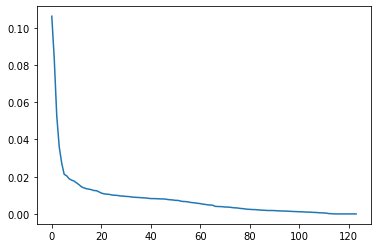

In [152]:
# Investigate the variance accounted for by each principal component.

plt.plot(pca.explained_variance_ratio_);

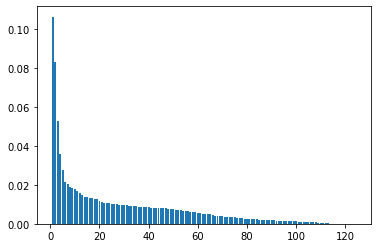

In [157]:
plt.bar(x = range(1, 125), height = pca.explained_variance_ratio_);

In [162]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)

In [217]:
pca_20.fit(azdias_scaled)

PCA(n_components=20)

In [218]:
azdias_pca = pca_20.transform(azdias_scaled)

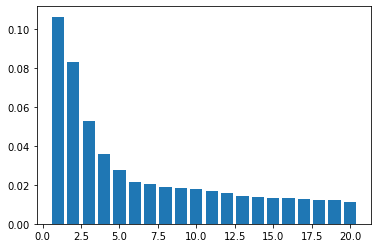

In [220]:
plt.bar(x=range(1,21), height=pca_20.explained_variance_ratio_);

### Discussion 2.2: Perform Dimensionality Reduction

Looking at the first graph with all the components included it looks to me that the graph starts to really level off around 20 so I decided to reapply the PCA model with 20 components and use that moving forward.

### Step 2.3: Interpret Principal Components



In [221]:
def map_feature_weights(component):
    
    '''
    Maps and displays sorted feature weights for each principal component available.
    
    Input - int: number of component to view, must be in range of components 1 to end. 
    Output - dataframe: sorted dataframe of linked feature weights from highest to lowest
    
    '''
    
    feature_weights = pca_20.components_
    index = component - 1
    feature_names = azdias_scaled.columns
    
    mapped_df = pd.DataFrame(feature_weights[index].reshape(1,124), columns=feature_names)
    
    name = 'Principal Component {}'.format(component)
    mapped_df.index = [name]
    
    return mapped_df.sort_values(by = name, axis=1, ascending=False)

In [222]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

map_feature_weights(1)

,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,ORTSGR_KLS9,EWDICHTE,WEALTH_5.0,FINANZ_HAUSBAUER,LIFE_STAGE_1.0,KBA05_ANTG4,PLZ8_ANTG2,...,LP_STATUS_FEIN_10.0,LP_LEBENSPHASE_GROB,INNENSTADT,PLZ8_GBZ,KONSUMNAEHE,KBA05_ANTG1,KBA05_GBZ,FINANZ_MINIMALIST,PLZ8_ANTG1,MOBI_REGIO
Principal Component 1,0.201671,0.196062,0.193853,0.172944,0.171199,0.164679,0.156446,0.154235,0.139585,0.138493,...,-0.117606,-0.128011,-0.143346,-0.14818,-0.149876,-0.196323,-0.196466,-0.199053,-0.202512,-0.205541


In [223]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_feature_weights(2)

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST,RETOURTYP_BK_S,DECADE_60s,W_KEIT_KIND_HH,CJT_GESAMTTYP_2.0,DECADE_50s,...,ONLINE_AFFINITAET,SEMIO_RAT,SEMIO_KULT,FINANZ_ANLEGER,DECADE_90s,SEMIO_PFLICHT,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_REL,FINANZ_SPARER
Principal Component 2,0.244489,0.225297,0.211632,0.200822,0.169999,0.159492,0.118312,0.116053,0.113221,0.1067,...,-0.164744,-0.16941,-0.186784,-0.203113,-0.207673,-0.214995,-0.218553,-0.218862,-0.231061,-0.232446


In [224]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_feature_weights(3)

,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZ_MINIMALIST,SHOPPER_TYP_0.0,ZABEOTYP_1,SEMIO_REL,RETOURTYP_BK_S,W_KEIT_KIND_HH,...,FINANZ_SPARER,LP_STATUS_FEIN_2.0,SHOPPER_TYP_2.0,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
Principal Component 3,0.330073,0.260064,0.257071,0.244296,0.139973,0.128637,0.111383,0.096629,0.091769,0.076264,...,-0.078663,-0.089245,-0.099509,-0.166721,-0.182506,-0.194352,-0.272835,-0.301021,-0.327005,-0.355587


### Discussion 2.3: Interpret Principal Components

**Principal Component 1**

> Top 5 Positive
>    - PLZ8_ANTG3: Number of 6-10 family houses in PLZ8 Region
>    - HH_EINKOMMEN_SCORE: Estimated household net income
>    - PLZ8_ANTG4: Number of 10+ family houses in PLZ8 Region
>    - ORTSGR_KLS9: size of community
>    - EWDICHTE: density of households per square km

> Top 5 Negative
>    - MOBI_REGIO: Movement patterns
>    - PLZ8_ANTG1: Number of 1-2 family houses in PLZ8 Region
>    - FINANZ_MINIMALIST: low financial interest typology	
>    - KBA05_GBZ: Number of buildings in RR3 microcell
>    - KBA05_ANTG1: Number of 1-2 family houses in RR3 microcell

**Principal Component 2**

> Top 5 Positive
>    - ALTERSKATEGORIE_GROB: estimated age based on given name
>    - FINANZ_VORSORGER: finance typology - be prepared
>    - ZABEOTYP_3: energy consumption typology - fair supplied
>    - SEMIO_ERL: personality typology - event minded
>    - SEMIO_LUST: personality typology - sensual minded

> Top 5 Negative
>    - FINANZ_SPARER: finance typology - money saver
>    - SEMIO_REL: personality typology - religious
>    - SEMIO_TRADV: personality typology - traditional minded
>    - FINANZ_UNAUFFAELLIGER: finance typology - inconspicuous
>    - SEMIO_PFLICHT: personality typology - dutiful	

**Principal Component 3**

> Top 5 Positive
>    - SEMIO_VERT: personality typology - dreamful
>    - SEMIO_SOZ: personality typology - socially minded
>    - SEMIO_FAM: personality typology - family minded	
>    - SEMIO_KULT: personality typology - cultural minded
>    - FINANZ_MINIMALIST: low financial interest typology

> Top 5 Negative
>    - ANREDE_KZ: gender
>    - SEMIO_KAEM: personality typology - combative attitude
>    - SEMIO_DOM: personality typology - dominant minded
>    - SEMIO_KRIT: personality typology -critical minded
>    - SEMIO_ERL: personality typology - event oriented

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population



In [225]:
# Over a number of different cluster counts...
scores = []
clusters = list(range(1,21))

for k in clusters:
    
    # run k-means clustering on the data and...    
    kmeans = KMeans(n_clusters=k)
    # compute the average within-cluster distances.
    model = kmeans.fit(azdias_pca)
    
    score = np.abs(model.score(azdias_pca))
    scores.append(score)
    

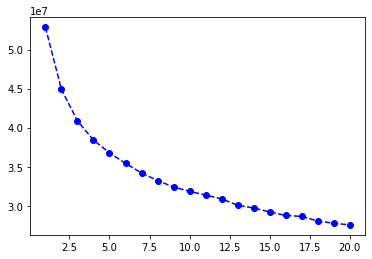

In [226]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(clusters, scores, linestyle='--', marker='o', color='b');

In [228]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=13)
azdias_model = kmeans.fit(azdias_pca)
azdias_clusters = azdias_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Looking at the graph that I ran for different clusters up to 20 clusters it appears to level off around 13 clusters. While there is some continuous drop off for each of the additional clusters there doesn't seem to be enough additional drop off to justify using more clusters. 

### Step 3.2: Apply All Steps to the Customer Data



In [229]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [230]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [233]:
customers_clean = clean_data(customers)

In [234]:
# check that cleaning function worked correctly to provide the right dimensions
customers_clean.shape[1] == azdias_scaled.shape[1]

True

In [235]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_full = impute.transform(customers_clean)

In [236]:
customers_scaled = pd.DataFrame(scale.transform(customers_full), columns=customers_clean.columns)

In [237]:
customers_pca = pca_20.transform(customers_scaled)

In [238]:
customer_clusters = azdias_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data



**I'll create a quick function to find the proportions from each of the two populations, customer and general. Once I have that I can create a plot to see which of the clusters are overrepresented or underrepresented and how those particular clusters are reflected by who is a part of them.**

In [239]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def cluster_proportions(predictions):
    
    """
    Returns the proportions of each of the clusters based on the Kmeans predictions. 
    
    Input - predictions: kmeans clustering predictions.
    Output - proportions: proportion of overall cluster sizes. 
    
    """
    
    df = pd.Series(predictions).value_counts()
    proportions = df / len(predictions)
    
    return proportions

In [240]:
# create the proportions for each population

population_proportions = cluster_proportions(azdias_clusters)
customer_proportions = cluster_proportions(customer_clusters)

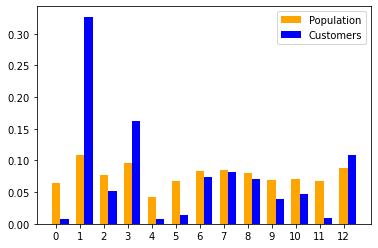

In [261]:
# see the plot of each proportion
ax = plt.subplot(111)

width=.35
ind = population_proportions.keys()

ax.bar(ind, height=population_proportions, width=width, color='orange')
ax.bar(ind + width, height=customer_proportions, width=width, color='blue')
ax.set_xticks(population_proportions.keys())
ax.legend(['Population', 'Customers']);

**In the above graph I can see that clusters one, three, and twelve are overrepresented in the customer data opposed to the general population. Where clusters zero, two, four, five, nine, ten, and eleven. In order to see what type of people make up each of the clusters I'll create a function so that I can roll back the PCA and Scaling on the dataframe so that I can see how each population is represented in the actual data.**

In [260]:

def reverse_discovery(df, cluster):
    """
    Reverts the scaled and PCA components to their original means in order to see what type of customers are represented in
    that particular cluster.
    
    Input - df - dataframe: which dataframe you want to revert
    Input - cluster - int: cluster you want to analyze
    
    Output - inverse_df mean - dataframe: means of all columns that have been reverted from StandardScaler and PCA
    
    """
    
    pca_inverse = pca_20.inverse_transform(df[np.where(customer_clusters == cluster)])
    scale_inverse = scale.inverse_transform(pca_inverse)
    inverse_df = pd.DataFrame(scale_inverse, columns=customers_scaled.columns)
    
    return inverse_df.mean()

In [262]:
# cluster one scaled back and analyzed - overrepresented
cluster_one = reverse_discovery(customers_pca, 1)

In [263]:
cluster_one

ALTERSKATEGORIE_GROB    3.825906
ANREDE_KZ               1.932920
FINANZ_MINIMALIST       2.664394
FINANZ_SPARER           1.500901
FINANZ_VORSORGER        4.665495
                          ...   
WEALTH_1.0              0.023920
WEALTH_2.0              0.078175
WEALTH_3.0              0.038977
WEALTH_4.0              0.406987
WEALTH_5.0              0.449679
Length: 124, dtype: float64

In [275]:
# wealth scores
cluster_one['CAMEO_DEUG_2015_1':'CAMEO_DEUG_2015_9']

CAMEO_DEUG_2015_1    0.027281
CAMEO_DEUG_2015_2   -0.003361
CAMEO_DEUG_2015_3    0.032240
CAMEO_DEUG_2015_4    0.045935
CAMEO_DEUG_2015_5    0.019856
CAMEO_DEUG_2015_6    0.224073
CAMEO_DEUG_2015_7    0.162649
CAMEO_DEUG_2015_8    0.282578
CAMEO_DEUG_2015_9    0.206488
dtype: float64

In [276]:
# income score
cluster_one['HH_EINKOMMEN_SCORE']

5.321918719154379

In [277]:
# household size
cluster_one['ANZ_PERSONEN']

1.4562396127691577

In [264]:
# cluster three scaled back and analyzed - overrepresented
cluster_three = reverse_discovery(customers_pca, 3)

In [265]:
cluster_three

ALTERSKATEGORIE_GROB    1.934091
ANREDE_KZ               1.989049
FINANZ_MINIMALIST       1.475701
FINANZ_SPARER           3.858450
FINANZ_VORSORGER        2.504233
                          ...   
WEALTH_1.0             -0.000364
WEALTH_2.0              0.018748
WEALTH_3.0              0.052876
WEALTH_4.0              0.376166
WEALTH_5.0              0.549971
Length: 124, dtype: float64

In [278]:
# wealth scores
cluster_three['CAMEO_DEUG_2015_1':'CAMEO_DEUG_2015_9']

CAMEO_DEUG_2015_1    0.011797
CAMEO_DEUG_2015_2   -0.012161
CAMEO_DEUG_2015_3   -0.000684
CAMEO_DEUG_2015_4    0.019432
CAMEO_DEUG_2015_5    0.037147
CAMEO_DEUG_2015_6    0.116342
CAMEO_DEUG_2015_7    0.207185
CAMEO_DEUG_2015_8    0.351110
CAMEO_DEUG_2015_9    0.267229
dtype: float64

In [279]:
# income score
cluster_three['HH_EINKOMMEN_SCORE']

5.4991354713209235

In [280]:
# household size
cluster_three['ANZ_PERSONEN']

1.6600226142003394

In [266]:
# cluster zero scaled back and analyzed - underrepresented
cluster_zero = reverse_discovery(customers_pca, 0)

In [281]:
cluster_zero

ALTERSKATEGORIE_GROB    3.668468
ANREDE_KZ               1.927869
FINANZ_MINIMALIST       4.292948
FINANZ_SPARER           1.353914
FINANZ_VORSORGER        4.478586
                          ...   
WEALTH_1.0              0.506647
WEALTH_2.0              0.258937
WEALTH_3.0              0.025966
WEALTH_4.0              0.146845
WEALTH_5.0              0.057618
Length: 124, dtype: float64

In [272]:
cluster_zero['CAMEO_DEUG_2015_1':'CAMEO_DEUG_2015_9']

CAMEO_DEUG_2015_1    0.213778
CAMEO_DEUG_2015_2    0.292869
CAMEO_DEUG_2015_3    0.118786
CAMEO_DEUG_2015_4    0.140151
CAMEO_DEUG_2015_5    0.020319
CAMEO_DEUG_2015_6    0.091866
CAMEO_DEUG_2015_7    0.046212
CAMEO_DEUG_2015_8    0.046565
CAMEO_DEUG_2015_9    0.025468
dtype: float64

In [273]:
cluster_zero['HH_EINKOMMEN_SCORE']

2.3315142107015516

In [274]:
cluster_zero['ANZ_PERSONEN']

2.4034782982981806

In [268]:
# cluster eleven scaled back and analyzed - underrepresented
cluster_eleven = reverse_discovery(customers_pca, 11)

In [269]:
cluster_eleven

ALTERSKATEGORIE_GROB    2.900535
ANREDE_KZ               1.632268
FINANZ_MINIMALIST       4.097918
FINANZ_SPARER           2.563133
FINANZ_VORSORGER        3.287448
                          ...   
WEALTH_1.0              0.194747
WEALTH_2.0              0.619968
WEALTH_3.0              0.067399
WEALTH_4.0              0.108617
WEALTH_5.0              0.002921
Length: 124, dtype: float64

In [282]:
# wealth scores
cluster_eleven['CAMEO_DEUG_2015_1':'CAMEO_DEUG_2015_9']

CAMEO_DEUG_2015_1    0.026292
CAMEO_DEUG_2015_2    0.168456
CAMEO_DEUG_2015_3    0.269257
CAMEO_DEUG_2015_4    0.350711
CAMEO_DEUG_2015_5    0.062268
CAMEO_DEUG_2015_6    0.068268
CAMEO_DEUG_2015_7    0.055641
CAMEO_DEUG_2015_8   -0.015547
CAMEO_DEUG_2015_9    0.008308
dtype: float64

In [283]:
# income score
cluster_eleven['HH_EINKOMMEN_SCORE']

3.2076486307611862

In [284]:
# household size
cluster_eleven['ANZ_PERSONEN']

2.9762867187323323

### Discussion 3.3: Compare Customer Data to Demographics Data

### Overrepresented in Customer Data Compared to General Population
>Looking at the above graph there are several clusters that appear to be overrepresented in the customer data opposed to the general population data, clusters one, three, and twelve. Clusters twelve is just slightly over the general population so I'll focus on one and three as those clusters are considerably higher than the general population data. 

> Starting with cluster one it appears that the general makeup of this cluster are people aged 46 to 60 (ALTERSKATEGORIE_GROB mean of around 3.8), who are female (ANREDE_KZ mean around 2), who tend to be low middle class to working class (CAMEO_DEUG_2015 6, 7, 8, and 9 highest means and HH_EINKOMMEN_SCORE of 5.3 indicating lower income), with a household size of between one and two (ANZ_PERSONEN mean of 1.4).

>Looking into cluster three it appears that some of the general makeup is people aged 30 to 35 (ALTERSKATEGORIE_GROB just below 2, so possibly skewing younger), who are female (ANREDE_KZ mean around 2), who tend to be of working class (CAMEO_DEUG_2015 7, 8, and 9 with the highest means and HH_EINKOMMEN_SCORE of 5.5 between lower income and very low income), with a smaller household between one and two (ANZ_PERSONEN mean of 1.6).

### Underrepresented in Customer Data Compared to General Population

>Looking at the above graph there are several clusters that appear to be underrepresented in the cusomter data opposed to the general population, clusters zero, two, four, five, nine, ten, and eleven. I'll be focusing on clusters zero and eleven as those appear to have the smallest proportion of customers in those clusters. 

>Starting with cluster zero it appears the general makeup of this cluster are people aged 46 to 60 (ALTERSKATEGORIE_GROB mean of 3.6, possibly skewing older), that are female (ANREDE_KZ mean of 1.9), who tend to be upper middle class to upper class (CAMEO_DEUG_2015 1, 2, 3 highest means with a HH_EINKOMMEN_SCORE score of 2.3 indicating high income), with a household size between two and three (ANZ_PERSONEN mean of 2.4). 

>Looking into cluster ten appears that the general makeup of this cluster are people aged 46 to 60 (ALTERSKATEGORIE_GROB mean of 3.4), that are possibly a mix of male and female (ANREDE_KZ mean of 1.5), who tend to be established middle class to upper class (CAMEO_DEUG_2015 2, 3, 4 are the highest means with a HH_EINKOMMEN_SCORE of 3.2 indicating high income), with a household around three people (ANZ_PERSONEN mean of 2.9).